In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression,LogisticRegression


# All plots can be displayed on notebooks:
%matplotlib inline

# Make better use of Jupyter Notebook cell width

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:99% !important; }</style>"))
pd.options.display.float_format = '{:.2f}'.format

In [4]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv

--2022-10-17 08:33:09--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 73250 (72K) [text/plain]
Saving to: ‘AER_credit_card_data.csv.1’

AER_credit_card_dat 100%[===================>]  71,53K  --.-KB/s    in 0,09s   

2022-10-17 08:33:09 (837 KB/s) - ‘AER_credit_card_data.csv.1’ saved [73250/73250]



In [15]:
df = pd.read_csv('AER_credit_card_data.csv')

# Preparation
- Create the target variable by mapping yes to 1 and no to 0.
- Split the dataset into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split function for that with random_state=1.

In [16]:
df.card = df.card.map({'yes':1,
            'no':0})

In [ ]:
df

In [19]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.card
y_val = df_val.card
y_test = df_test.card

del df_train['card']
del df_val['card']
del df_test['card']

# Question 1
- ROC AUC could also be used to evaluate feature importance of numerical variables.

- Let's do that

- For each numerical variable, use it as score and compute AUC with the card variable.
- Use the training dataset for that.
- If your AUC is < 0.5, invert this variable by putting "-" in front

In [39]:
##

numerical = ["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active"]
categorical = ["owner", "selfemp"]

In [60]:
from sklearn.metrics import roc_auc_score,roc_curve

In [49]:
#CALCULATING ROC AUC SCORE:
for c in numerical:
    auc = roc_auc_score(y_train, df_train[c])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[c])
    print('%9s, %.3f' % (c, auc))

  reports, 0.717
      age, 0.524
   income, 0.591
    share, 0.989
expenditure, 0.991
dependents, 0.533
   months, 0.529
majorcards, 0.534
   active, 0.604


# Training the model

- Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

#LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

In [55]:
train_dict = df_train[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer(sparse=False)
dv.fit(train_dict)

X_train = dv.transform(train_dict)
 
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]

# Question 2
- What's the AUC of this model on the validation dataset? (round to 3 digits)

In [58]:
from sklearn.metrics import auc

In [63]:
roc_auc_score(y_val,y_pred)

0.995171242063847

# Question 3
- Now let's compute precision and recall for our model.

- Evaluate the model on the validation dataset on all thresholds from 0.0 to 1.0 with step 0.01
- For each threshold, compute precision and recall
- Plot them
- At which threshold precision and recall curves intersect?

In [65]:
np.arange(0, 1, 0.01)

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99])

In [87]:
# CREATING CONFUSION MATRIX:
def confusion_matrix_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()
        
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)

        scores.append((t,tp,fp,fn,tn, precision, recall))

    columns = ['threshold','tp','fp','fn','tn','precision', 'recall']
    df_scores = pd.DataFrame(scores, columns=columns)
    
    return df_scores


# IMPLEMENTATION OF FUNCTION:
df_scores = confusion_matrix_dataframe(y_val, y_pred)
df_scores[::10]

,threshold,tp,fp,fn,tn,precision,recall
0,0.00,211,53,0,0,0.80,1.00
10,0.10,210,17,1,36,0.93,1.00
20,0.20,207,5,4,48,0.98,0.98
30,0.30,205,5,6,48,0.98,0.97
40,0.40,205,1,6,52,1.00,0.97
50,0.50,204,1,7,52,1.00,0.97
60,0.60,204,1,7,52,1.00,0.97
70,0.70,204,1,7,52,1.00,0.97
80,0.80,204,1,7,52,1.00,0.97
90,0.90,204,0,7,53,1.00,0.97


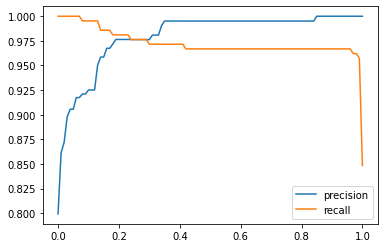

In [85]:
# INSPECTING THE CURVES:
plt.plot(df_scores.threshold, df_scores.precision, label='precision')
plt.plot(df_scores.threshold, df_scores.recall, label='recall')

plt.legend()
plt.show()

# Question 4

- Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both


- Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01 using the validation set

- At which threshold F1 is maximal?

In [95]:
#@ GETTING F1 SCORES:
df_scores['f1'] = 2 * df_scores.precision * df_scores.recall / (df_scores.precision + df_scores.recall)

In [91]:
recall

0.966824644549763

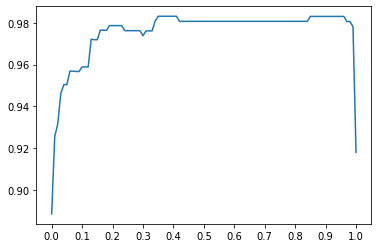

In [102]:
#@ INSPECTING F1 SCORE:
plt.plot(df_scores.threshold, df_scores.f1)
plt.xticks(np.linspace(0, 1, 11))
plt.show()

# Question 5

- Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

- KFold(n_splits=5, shuffle=True, random_state=1)
- Iterate over different folds of df_full_train
- Split the data into train and validation
- Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
- Use AUC to evaluate the model on validation
- How large is standard devidation of the AUC scores across different folds?

In [114]:
#@ DEFINING TRAIN AND PREDICT FUNCTION:
def train(df_train, y_train, C=1.0):
    dicts = df_train[numerical + categorical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C)
    model.fit(X_train, y_train)

    return dv, model

In [115]:
def predict(df, dv, model):
    dicts = df[numerical + categorical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [106]:
from sklearn.model_selection import KFold

In [118]:
# INITIALIZING KFOLD CROSS VALIDATION:
scores = []

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.card
    y_val = df_val.card

    dv, model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))
    

0.996 +- 0.003


# Question 6
- Now let's use 5-Fold cross-validation to find the best parameter C

- Iterate over the following C values: [0.01, 0.1, 1, 10]
- Initialize KFold with the same parameters as previously
- Use these parametes for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
- Compute the mean score as well as the std (round the mean and std to 3 decimal digits)
- Which C leads to the best mean score?

In [122]:
#@ INSPECTING KFOLD CROSS VALIDATION:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for C in [0.01, 0.1, 1, 10]:
    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.card
        y_val = df_val.card

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%4s, %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C=0.01, 0.992 +- 0.006
C= 0.1, 0.995 +- 0.004
C=   1, 0.996 +- 0.003
C=  10, 0.996 +- 0.003


In [123]:
#C=  10, 0.996 +- 0.003